In [60]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.dpi': 150, 'figure.figsize': (9, 6)})

from ggt.data import FITSDataset, get_data_loader
from ggt.models import model_factory, model_stats, save_trained_model
from ggt.utils import discover_devices, tensor_to_numpy

In [2]:
device = discover_devices()
device

'cuda'

In [26]:
model_path = "../models/ggt-exp-1-balanced-lg-ae65fdee7c284d0da4388455c459e2d6.pt"

In [14]:
cls = model_factory('ggt')
model = cls()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [27]:
data_dir = Path("../data/sdss/")
fits_dir = data_dir / "cutouts"

In [ ]:
# PosixPath('../data/sdss/cutouts/587738570323394762-g.fits')

In [365]:
catalog = pd.read_csv(data_dir / "info.csv")
fits_path = fits_dir / catalog.file_name.sample().item()
fits_path

PosixPath('../data/sdss/cutouts/587739294549475448-g.fits')

In [366]:
X = FITSDataset.load_fits_as_tensor(fits_path).view((1, 167, 167))
X = FITSDataset.arsinh_normalize(X).view((1, 1, 167, 167))
with torch.no_grad():
    Xt = model.spatial_transform(X)

In [367]:
with torch.no_grad():
    xs = model.localization(X)
    xs = xs.view(-1, 96 * 34 * 34)
    theta = model.fc_loc(xs)
    theta = theta.view(-1, 2, 3)

    grid = F.affine_grid(theta, X.size(), align_corners=True)
    Xt = F.grid_sample(X, grid, align_corners=True)

In [368]:
theta

tensor([[[ 0.4832, -0.0309,  0.0194],
         [ 0.0324,  0.4773,  0.0222]]])

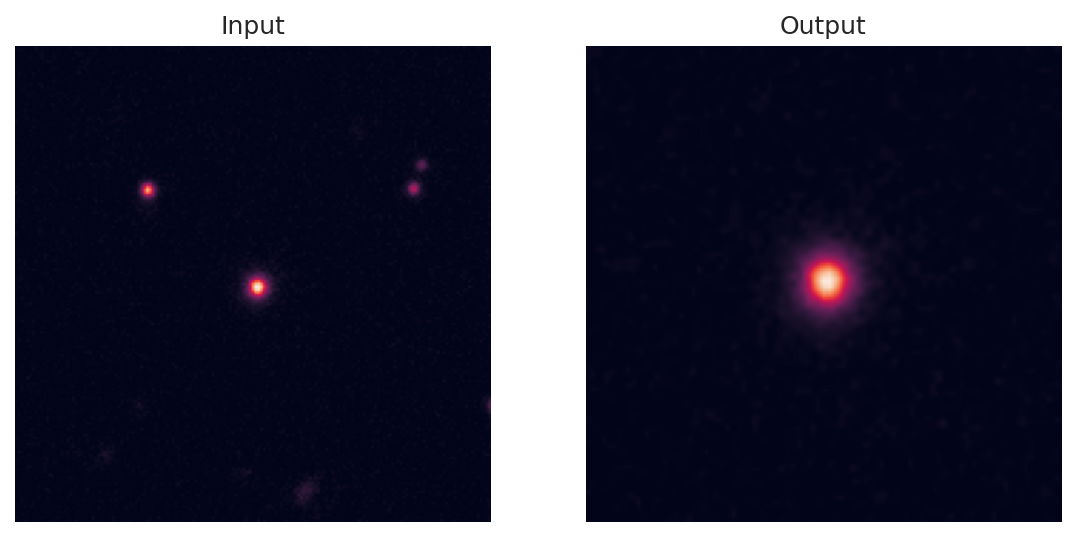

In [305]:
fig, ax = plt.subplots(1, 2)
for a in ax:
    a.grid('off')
    a.axis('off')
ax[0].imshow(tensor_to_numpy(X.view((1, 167, 167))))
# ax[0].scatter([67], [67])
ax[0].set_title('Input')
ax[1].imshow(tensor_to_numpy(Xt.view((1, 167, 167))))
# ax[1].scatter([61.3352], [58.7162])
ax[1].set_title('Output')
plt.show()